In [3]:
from sodapy import Socrata
import pandas as pd
import requests as re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from census_area import Census
import geopandas as gpd
from shapely.geometry import Point
from decimal import Decimal
from census_area import Census

## Question 1
## 1.a.
The following uses the code provided by the Chicago crime data web page to download information through the API. This file was modified in order to get the data for the years 2017 and 2018.

In [4]:
#Obtain the data for later working with it

#code_dict = {'y_17': "d62x-nvdr", 'y_18': "3i3m-jwuy"}
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", 'ddiis7oK7xxQ32iQrjb6ZRurs')

results = client.get('6zsd-86xi',where = "year between \
                     '2017' and '2018'", limit = 600000)
# Convert to pandas DataFrame
crime_data = pd.DataFrame.from_records(results)


In [5]:
comm_areas = {
"1": "Rogers Park", "2": "West Ridge", "3": "Uptown","4": "Lincoln Square",
"5": "North Center", "6": "Lakeview", "7": "Lincoln Park","8": "Near North Side","9": "Edison Park",
"10": "Norwood Park", "11": "Jefferson Park", "12": "Forest Glen", "13": "North Park", "14": "Albany Park",
"15": "Portage Park", "16": "Irving Park", "17": "Dunning", "18": "Montclare",
"19": "Belmont Cragin", "20": "Hermosa", "21": "Avondale", "22": "Logan Square",
"23": "Humboldt Park", "24": "West Town", "25": "Austin","26": "West Garfield Park",
"27": "East Garfield Park", "28": "Near West Side", "29": "North Lawndale","30": "South Lawndale",
"31": "Lower West Side", "32": "Loop", "33": "Near South Side", "34": "Armour Square",
"35": "Douglas", "36": "Oakland", "37": "Fuller Park", "38": "Grand Boulevard",
"39": "Kenwood", "40": "Washington Park", "41": "Hyde Park", "42": "Woodlawn",
"43": "South Shore", "44": "Chatham", "45": "Avalon Park", "46": "South",
"47": "Burnside", "48": "Calumet Heights", "49": "Roseland","50": "Pullman",
"51": "South Deering", "52": "East Side", "53": "West Pullman", "54": "Riverdale",
"55": "Hegewisch", "56": "Garfield Ridge", "57": "Archer Heights", "58": "Brighton Park",
"59": "McKinley Park", "60": "Bridgeport", "61": "New City", "62": "West Elsdon",
"63": "Gage Park", "64": "Clearing", "65": "West Lawn", "66": "Chicago Lawn",
"67": "West Englewood", "68": "Englewood", "69": "Greater Grand Crossing", "70": "Ashburn",
"71": "Auburn Gresham", "72": "Beverly", "73": "Washington Heights", "74": "Mount Greenwood",
"75": "Morgan Park", "76": "O'Hare", "77": "Edgewater"
}

crime_data['community area'] = crime_data['community_area'].map(comm_areas)
del crime_data['community_area']

## 1.b. 
Next, we ilustrate the crime situation in Chicago by exploring two main variables: Primary Type of Crime and Community Areas in which this happen.  The first graph bring information about the most frequent primary types of crime per year. 


Text(0.5, 1.0, 'Number of crimes per primary type')

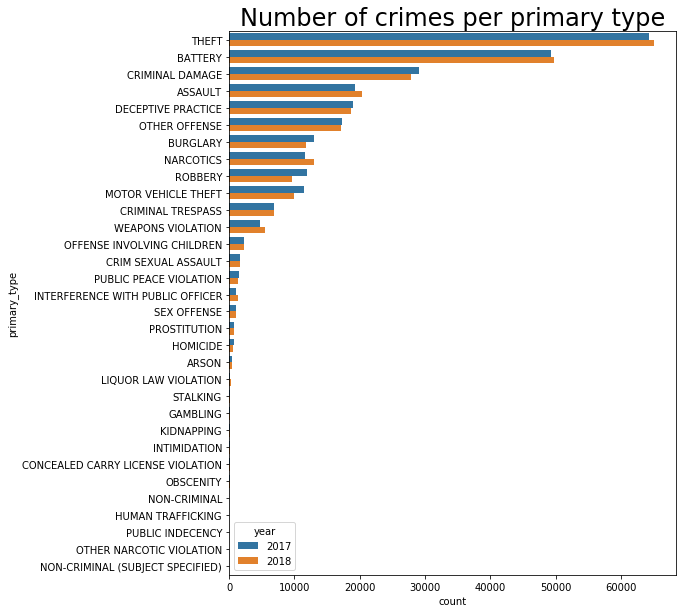

In [6]:
def prim_type_df(str_lst, data):
    newdf = data.groupby(str_lst).size().sort_values(ascending=False).reset_index()
    newdf.rename(columns={0:'count'}, inplace=True)
    return newdf

newdf = prim_type_df(['primary_type', 'year'],crime_data)
plt.figure(figsize = (8,10))
ax = sns.barplot(x = "count", y = "primary_type", hue = 'year', data = newdf)
plt.title("Number of crimes per primary type", fontsize = 24)


The second graph brings information about the community areas that have the highest numbers of crimes.

In [7]:
newdf = prim_type_df(['primary_type','year'], crime_data)
newdf = newdf.sort_values(['count'])
pivot_df = pd.pivot_table(newdf, values = 'count', index = ['primary_type'],
                       columns = ['year']).reset_index()
pivot_df.columns.name = None
pivot_df = pivot_df.sort_values(['2018'])
pivot_df['Variation rate'] = (pivot_df['2018']/pivot_df['2017'] -1)*100

cm = sns.light_palette("red", as_cmap = True)
s = pivot_df.style.background_gradient(cmap = cm)
s

,primary_type,2017,2018,Variation rate
22,OTHER NARCOTIC VIOLATION,11,1,-90.9091
19,NON-CRIMINAL (SUBJECT SPECIFIED),2,3,50
25,PUBLIC INDECENCY,10,14,40
11,HUMAN TRAFFICKING,9,14,55.5556
18,NON-CRIMINAL,38,37,-2.63158
20,OBSCENITY,87,86,-1.14943
4,CONCEALED CARRY LICENSE VIOLATION,69,149,115.942
13,INTIMIDATION,151,168,11.2583
14,KIDNAPPING,190,169,-11.0526
9,GAMBLING,191,201,5.2356


Text(0.5, 1.0, 'Number of crimes per community areas')

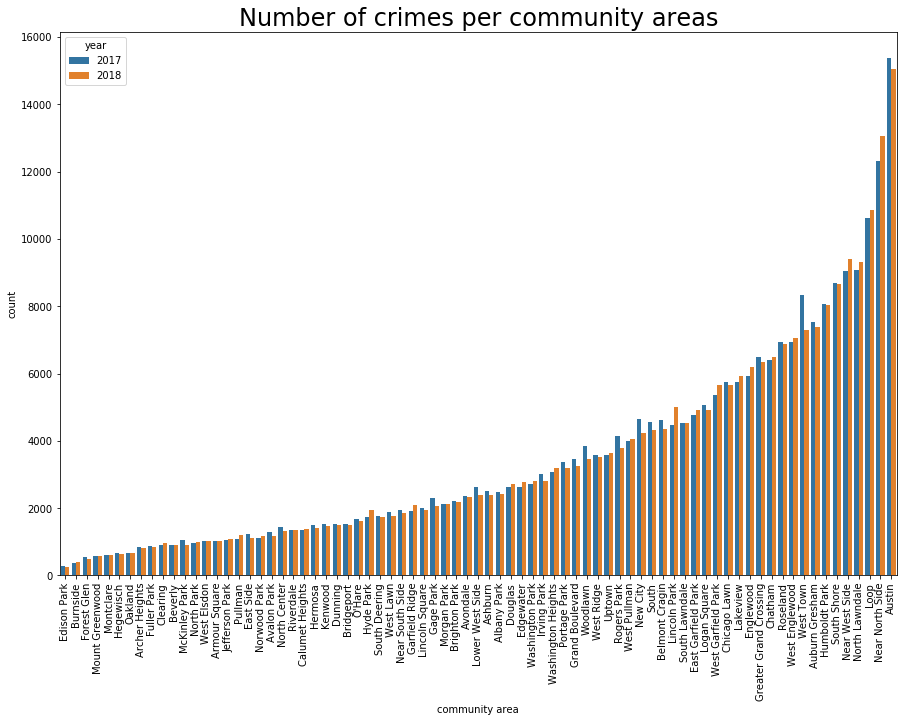

In [8]:
newdf = prim_type_df(['community area','year'],crime_data)
newdf = newdf.sort_values(['count'])
plt.figure(figsize=(15,10))
graph = sns.barplot(x = "community area", y = "count", hue = 'year', data = newdf)
for item in graph.get_xticklabels():
    item.set_rotation(90)
plt.title("Number of crimes per community areas", fontsize = 24)


In [9]:
newdf = prim_type_df(['community area','year'], crime_data)
newdf = newdf.sort_values(['count'])
pivot_df = pd.pivot_table(newdf, values = 'count', index = ['community area'],
                       columns = ['year']).reset_index()
pivot_df.columns.name = None
pivot_df = pivot_df.sort_values(['2018'])
pivot_df['Variation rate'] = (pivot_df['2018']/pivot_df['2017'] -1)*100

cm = sns.light_palette("red", as_cmap = True)
s = pivot_df.style.background_gradient(cmap = cm)
s

,community area,2017,2018,Variation rate
22,Edison Park,275,253,-8
12,Burnside,370,385,4.05405
24,Forest Glen,548,494,-9.85401
46,Mount Greenwood,585,564,-3.58974
44,Montclare,608,597,-1.80921
30,Hegewisch,672,622,-7.44048
56,Oakland,680,664,-2.35294
1,Archer Heights,849,817,-3.76914
25,Fuller Park,880,836,-5
43,McKinley Park,1052,906,-13.8783


#### The third graph gives information about the rate of growth of the crimes per neighborhood 

Text(0.5, 1.0, 'Variation rate of crimes per community areas')

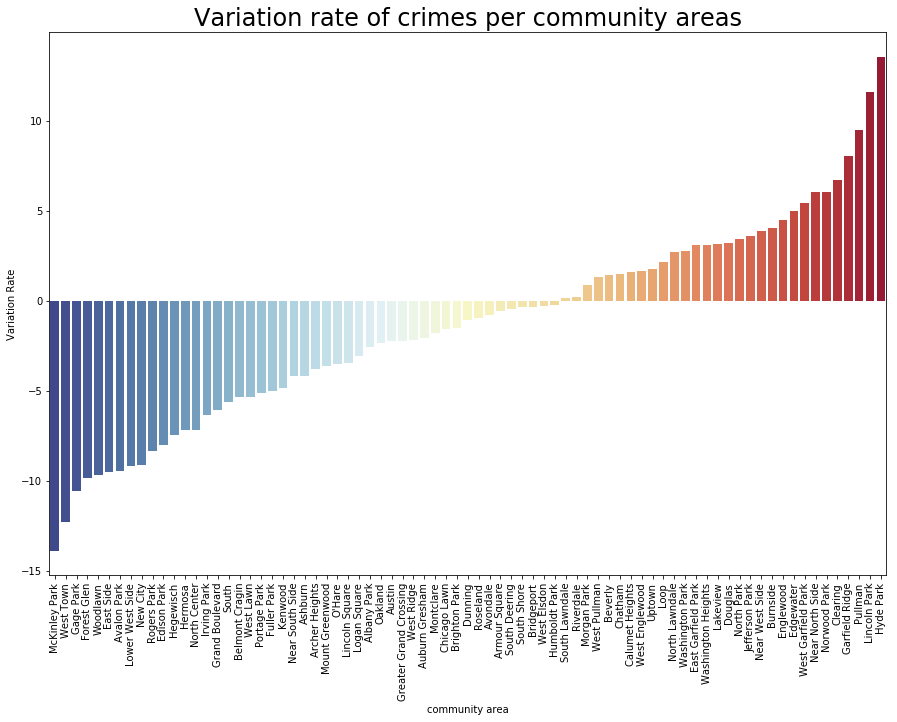

In [10]:
def comm_area_df(char,data):
    newdf2 = data.groupby(['year','{}'.format(char)]).size().sort_values(ascending = False).reset_index()
    newdf2.rename(columns={0:'count'}, inplace = True)
    newdf2 = newdf2.pivot(index='{}'.format(char), columns = 'year', values = 'count').reset_index()
    newdf2['Variation Rate'] = ((newdf2['2018'] - newdf2['2017'])/newdf2['2017'])*100
    newdf2.columns.name = None
    newdf2 = newdf2[newdf2['Variation Rate']!= 100]
    newdf2 = newdf2.sort_values('Variation Rate', ascending=True)
    return newdf2

newdf2 = comm_area_df('community area', crime_data)
newdf2 = newdf2[['community area', 'Variation Rate']]
plt.figure(figsize=(15, 10))
graph = sns.barplot(x = "community area", y = "Variation Rate", data = newdf2, palette = ('RdYlBu_r'))
for item in graph.get_xticklabels():
    item.set_rotation(90)

plt.title("Variation rate of crimes per community areas", fontsize = 24)

 The following 5 graphs present the most frequent types of crimes per community area. We can see that, depending on the crime and the location, the number of cases has increased greatly. On the contrary, we can also see that in some cases, crime has decreased greatly.

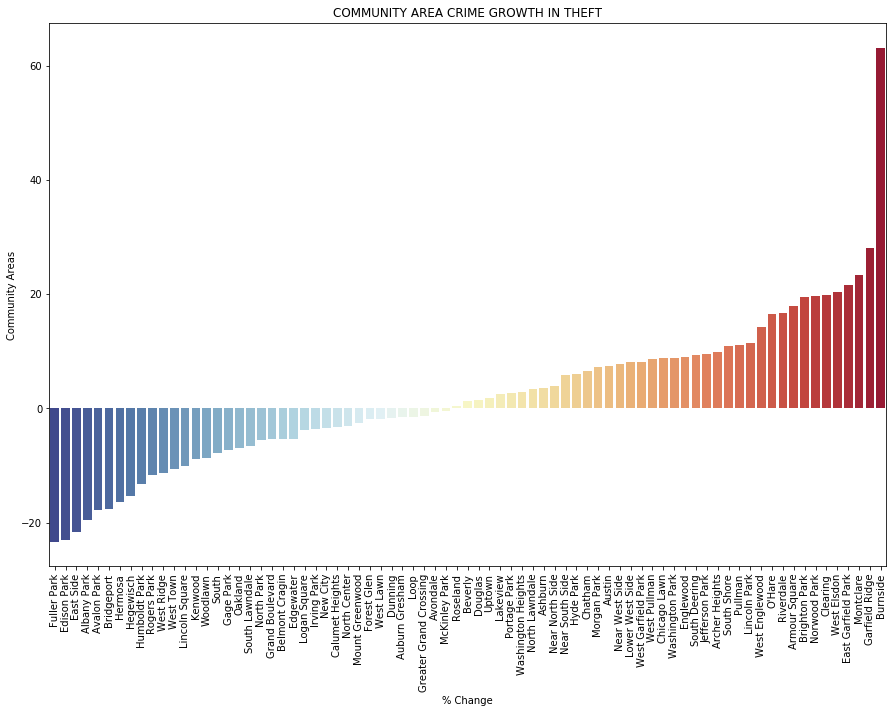

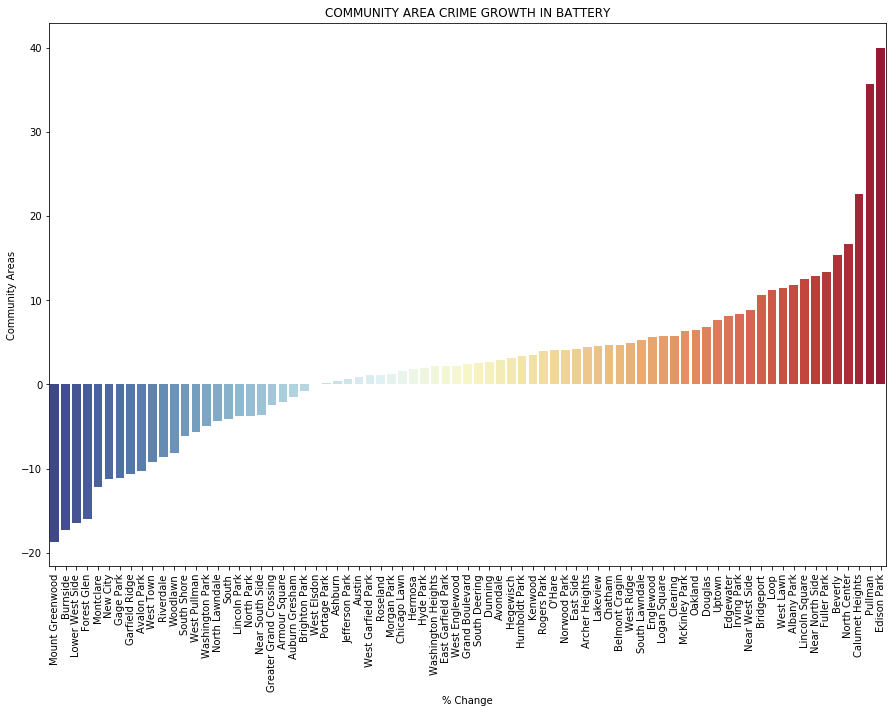

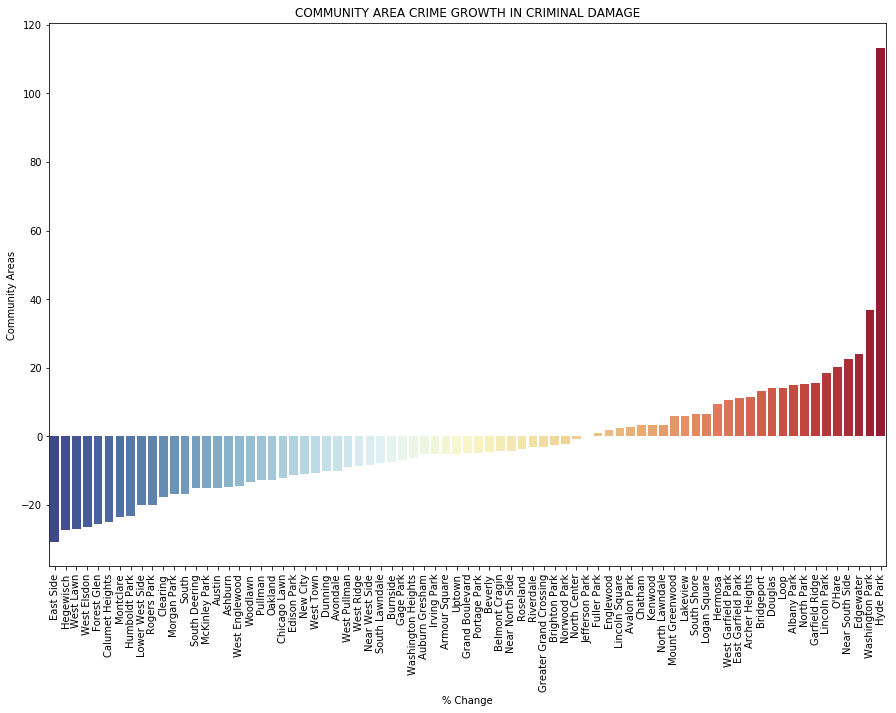

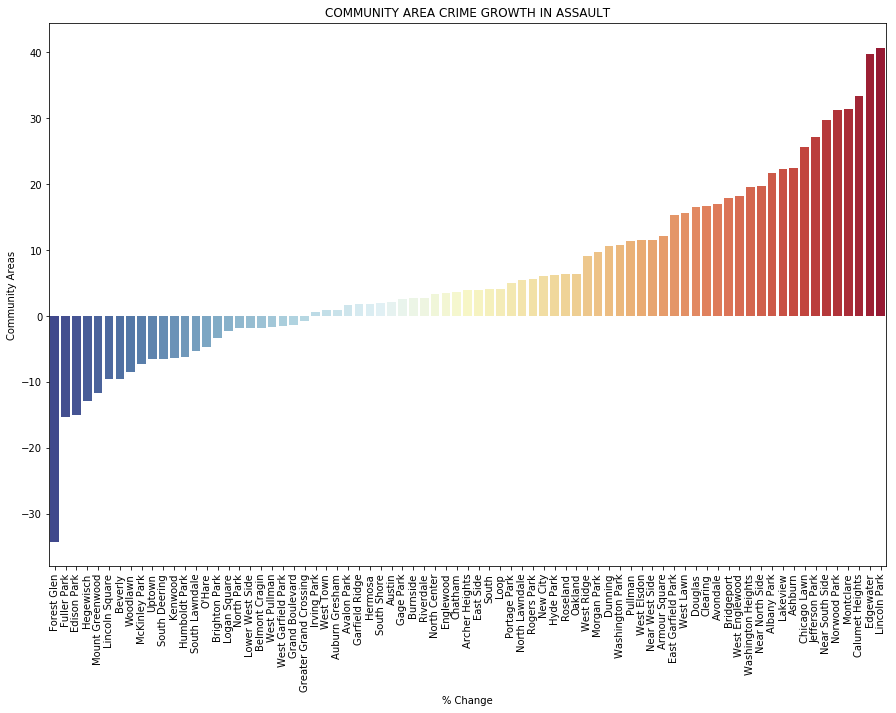

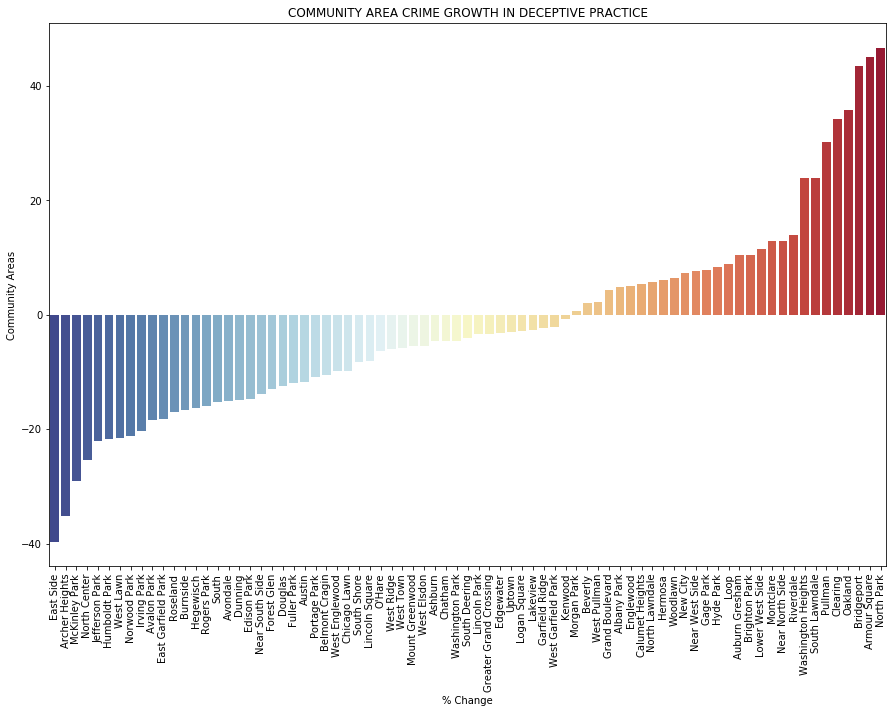

In [11]:
crime_lst = list(crime_data['primary_type'].value_counts()[:5].index)

for crime in crime_lst:
    crime_df = crime_data[crime_data['primary_type'] == crime]
    newdf2 = comm_area_df('community area',crime_df)
    newdf2 = newdf2[['community area', 'Variation Rate']]
    plt.figure(figsize=(15,10))
    graph = sns.barplot(x="community area", y="Variation Rate", data=newdf2,palette=('RdYlBu_r'))
    for item in graph.get_xticklabels():
        item.set_rotation(90)
        plt.title('COMMUNITY AREA CRIME GROWTH IN {}'.format(crime))
        plt.ylabel('Community Areas')
        plt.xlabel('% Change')

## Question 2
## 2.0
We download the American Community Census  (ACS) data for 5 year estimates (2013 -2017) in order to get the data for block groups.  This task is accomplished through the datamade wrapper developed by the Sunlight Foundation. Next, we load the shapefile where the geolocation of the block groups are available.  These geolocation is registered by polygons. Next, we perform a spatial join between the ACS data and the Chicago Crime Data. 

In [12]:
#List of counties that conform Chicago extracted from https://en.wikipedia.org/wiki/Chicago_metropolitan_area
county_list = ['031', '037', '043', '063', '089']
#county_list = ['031']

def get_acs_data(county_list):
    c = Census("782594777378b4dae32651de41285b8430095ed4")
    df_acs = None
    for county in county_list:    
        data = c.acs5.state_county_blockgroup(('NAME', 'B19001_002E', 
                                               'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E',
                                               'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E',
                                               'B19001_011E', 'B19001_012E', 'B19001_013E', 'B19001_014E',
                                               'B19001_015E', 'B19001_016E', 'B19001_017E',
                                               'B02001_002E', 'B02001_003E', 'B02001_004E',
                                               'B02001_005E', 'B02001_006E', 'B02001_007E', 'B02001_008E',
                                               'B02001_009E', 'B02001_010E',
                                               'B11016_003E', 'B11016_004E',
                                               'B11016_005E', 'B11016_006E', 'B11016_007E', 'B11016_008E')
                                               , '17', county, Census.ALL) 
        df_data = pd.DataFrame(data)
        if df_acs is None:
            df_acs = df_data
        else:
            lst = [df_acs, df_data]
            df_acs = pd.concat(lst)
    return df_acs
df_acs = get_acs_data(county_list)


In [13]:
#Shapefile with the coordinates of each block, downloaded manually from the following webpage

lat_lon = gpd.read_file('/home/student/Downloads/tl_2018_17_bg/tl_2018_17_bg.shp')
df_acs['GEOID']=df_acs['state']+df_acs['county']+df_acs['tract']+df_acs['block group']

df_acs_coord = pd.merge(df_acs, lat_lon
                  , how ='left', on = 'GEOID')

crime_data = crime_data.dropna(subset = ['longitude', 'latitude'])

for col in ['longitude', 'latitude']:
    crime_data[col] = crime_data[col].astype('float')
    
agg_crime_data = crime_data.groupby(['year','primary_type',
                                     'block', 'latitude', 'longitude']) \
                                    .size().sort_values(ascending=False). \
                                    reset_index()

geom = agg_crime_data.apply(lambda x : Point([x['longitude'],x['latitude']]),axis = 1)
geo_crime_data = gpd.GeoDataFrame(agg_crime_data, geometry = geom)
geo_acs = gpd.GeoDataFrame(df_acs_coord,geometry = df_acs_coord['geometry'])

final_join = gpd.sjoin(geo_crime_data, geo_acs, how = "left", op='intersects')
final_join.rename(columns = {0:'count'}, inplace = True)

In [22]:
final_join[:5]

,year,primary_type,block,latitude,longitude,count,geometry,index_right,B02001_002E,B02001_003E,...,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,2017,THEFT,001XX N STATE ST,41.883500,-87.627877,422,POINT (-87.62787669799999 41.883500187),340.0,2468.0,164.0,...,031,320100,1,Block Group 1,G5030,S,407330.0,0.0,+41.8829215,-087.6206068
1,2018,THEFT,001XX N STATE ST,41.883500,-87.627877,354,POINT (-87.62787669799999 41.883500187),340.0,2468.0,164.0,...,031,320100,1,Block Group 1,G5030,S,407330.0,0.0,+41.8829215,-087.6206068
2,2017,NARCOTICS,033XX W FILLMORE ST,41.868181,-87.709271,252,POINT (-87.70927138899999 41.868180939),3301.0,0.0,1400.0,...,031,843000,1,Block Group 1,G5030,S,487117.0,0.0,+41.8681494,-087.7129516
3,2018,THEFT,0000X N STATE ST,41.882394,-87.627845,242,POINT (-87.627844798 41.882394062),2835.0,2523.0,548.0,...,031,839100,1,Block Group 1,G5030,S,777683.0,63678.0,+41.8828966,-087.6316474
4,2018,THEFT,011XX S CANAL ST,41.868542,-87.639235,221,POINT (-87.639235361 41.868541914),3297.0,1900.0,847.0,...,031,841900,2,Block Group 2,G5030,S,1655622.0,51851.0,+41.8657562,-087.6414114


In [15]:
race_cat = {'B02001_002E': 'white alone', 
            'B02001_003E': 'black alone',
            'B02001_004E': 'native alone',
            'B02001_005E': 'asian alone',
            'B02001_006E': 'pacific alone',
            'B02001_007E': 'other alone',
            'B02001_008E': 'two or more',
            'B02001_009E': 'two or more some other'}

inc_cat = {'B19001_002E': 'less10k', 'B19001_003E': '10kto15k',
            'B19001_004E': '15kto20k', 'B19001_005E': '20kto25k',
            'B19001_006E': '25kto30k', 'B19001_007E': '30kto35k',
            'B19001_008E': '35kto40k', 'B19001_009E': '40kto45k',
            'B19001_010E': '45kto50k', 'B19001_011E': '50kto55k',
            'B19001_012E': '60kto75k', 'B19001_013E': '75kto100k',
            'B19001_014E': '100kto125k', 'B19001_015E': '125kto145k',
            'B19001_016E': '150kto200k', 'B19001_017E': '200kmore'}

family_cat = {'B11016_003E': '2 person',
              'B11016_004E': '3 person',
              'B11016_005E': '4 person',
              'B11016_006E': '5 person',
              'B11016_007E': '6 person',
              'B11016_008E': '7+ person'}


def turn_to_perc(df, pref,new_cat):
    
    df_ = {}
    filter_col = [col for col in df if col.startswith(pref)]
    
    small_df = df[filter_col]
    for col in filter_col:
        value = small_df[col].sum()
        df_[col] = [value]
    df = pd.DataFrame.from_dict(df_)
    df['Total'] = df.sum(axis = 1)
    for col in filter_col:
        df[col] = df[col]/df['Total']*100
    del df['Total']
    df.rename(columns = new_cat,inplace = True)
    return df

def delimit_df(df,primary_type, year):
    graph_df = df[(df['primary_type'] == primary_type) & (df['year'] == year)]
    return graph_df

first_crime = ['BATTERY', 'HOMICIDE']
second_crime = ['DECEPTIVE PRACTICE','SEX OFFENSE']

#question 1
dcat = {'B02001_00':race_cat,'B19001_00':inc_cat, 'B11016_00':family_cat}
pref = {'Race':'B02001_00', 'Income':'B19001_00', 'Family Size':'B11016_00'}

def graph_crime(crime):
    small_df = delimit_df(final_join,crime, '2018')
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(25, 10))  # 1 row, 2 columns
    for key, val in pref.items():
        small_df_perc = turn_to_perc(small_df, val, dcat[val])
        small_df_perc.rename(index = {0:'{} BG'.format(crime)}, inplace=True)
        big_comparison = turn_to_perc(df_acs_coord, val, dcat[val])
        big_comparison.rename(index = {0:'Total BG'}, inplace=True)
        appended = small_df_perc.append(big_comparison)
        if key == 'Race':
            appended.plot(kind="bar", stacked=True, rot=0, ax=ax1, title = key, fontsize = 22)
        elif key == 'Income':
            appended.plot(kind="bar", stacked=True, rot=0, ax=ax2, title = key, fontsize = 22)
        elif key == 'Family Size':
            appended.plot(kind="bar", stacked=True, rot=0, ax=ax3, title = key, fontsize = 22)
        ax1.title.set_size(24)
        ax2.title.set_size(24)
        ax3.title.set_size(24)
        ax1.legend(prop={'size': 15})
        ax2.legend(prop={'size': 15})
        ax3.legend(prop={'size': 15})

    return fig.show()


## 2.1.
Following, the comparison between the block groups that have reporter batteries and all the block groups in general are presented. The block groups that have reports of batteries are, acoording to the graphs, more poor. The distribution of income is show that there is more presence of households that earn less than 10k per year and 25k per year. Also, they are predominantly black . in terms of family size, the distribution is similar. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


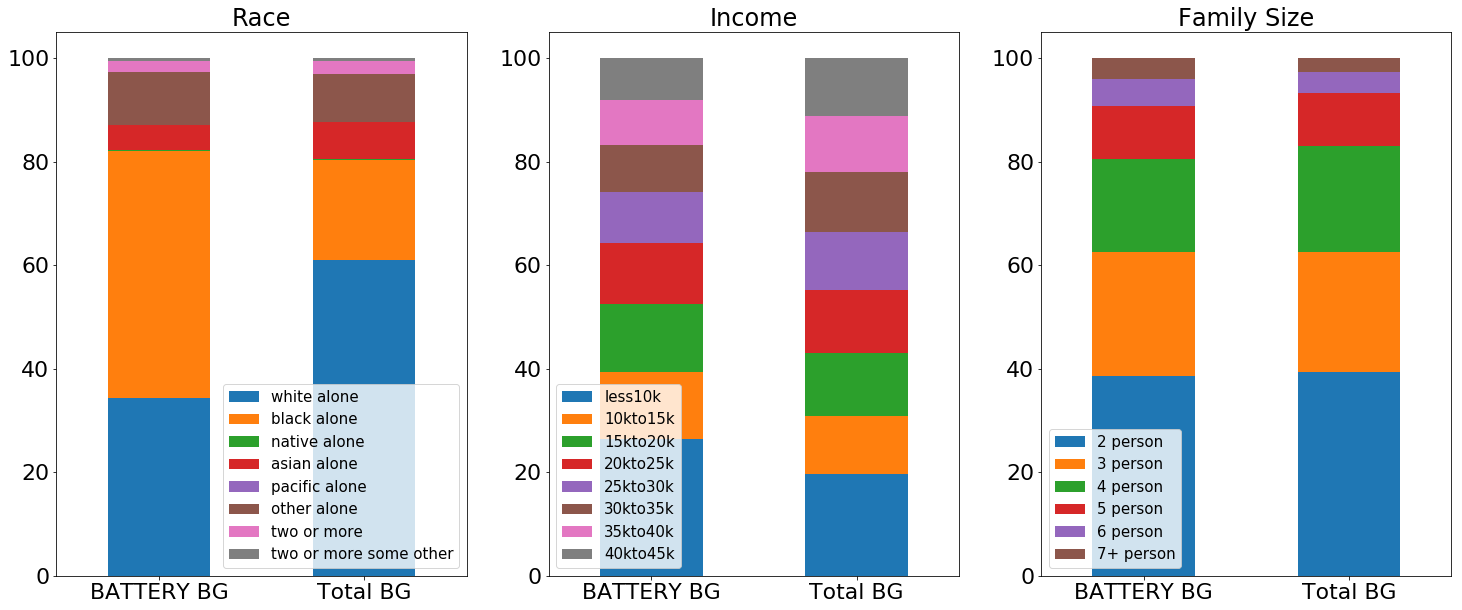

In [16]:
graph_crime('BATTERY')

## 2.2 
Regarding the comparison between the block groups that have reported at least one homicide incident, we can clearly see that there is a racial component in the occurrence of these event.  Block groups that report homicide are mainly inhabited by black people, while block groups that don't report homicide, are mainly white. The income level is worse in these blocks too. Family size is also similar

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


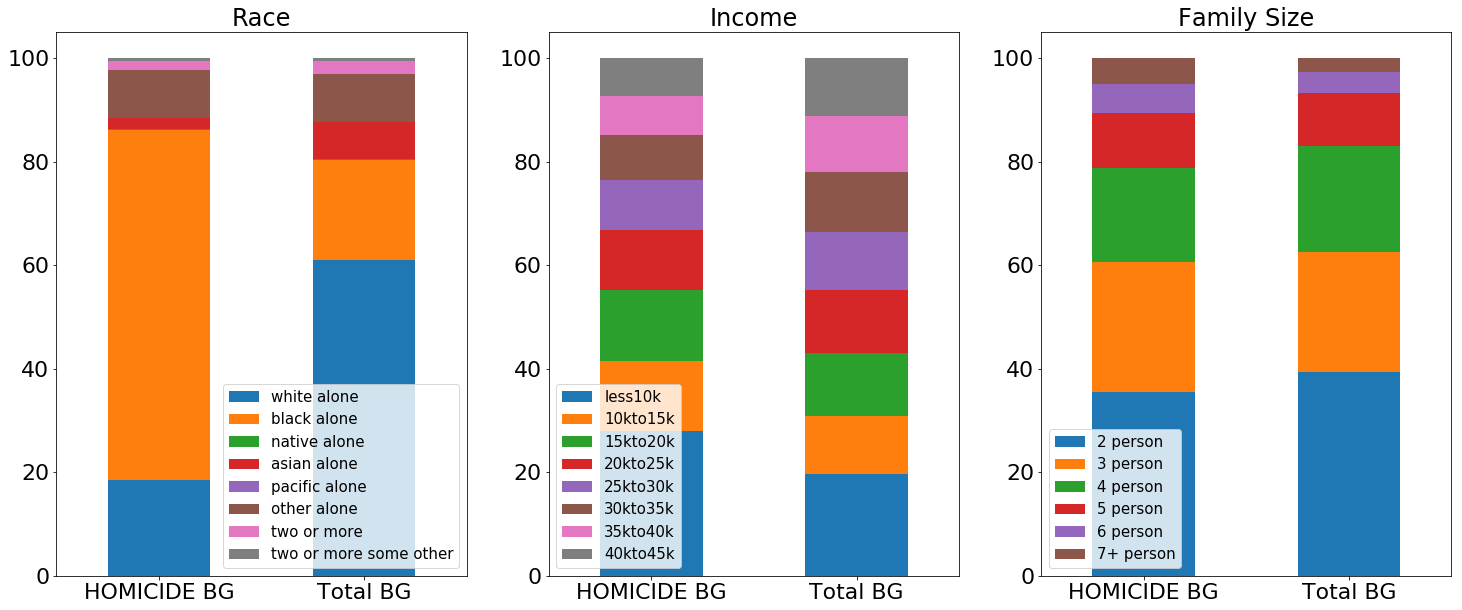

In [17]:
graph_crime('HOMICIDE')

## 2.3 
The following graphs show the change in percentage distribution of each demographic characteristics. Observing the changes (from 2017 to 2018) of demographic characteristics for block groups in which Battery incidents have happened, some tendencies appear, mostly, in race: For batteries, blocks with black populations are less representative and block populations, more representative.  For homicides, blocks with black population are much more representative in 2018. In the case of income, this characteristic is significant 

In [18]:

def change_year(crime):
    df_17 = delimit_df(final_join, crime, '2017')
    df_18 = delimit_df(final_join, crime, '2018')
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25, 10))  # 1 row, 2 columns

    for key, val in pref.items():
        small_df_17 = turn_to_perc(df_17, val, dcat[val])
        small_df_17.rename(index={0:'2017'}, inplace=True)
        small_df_18 = turn_to_perc(df_18, val, dcat[val])
        small_df_18.rename(index={0:'2018'}, inplace=True)
        appended = small_df_17.append(small_df_18)
        if key == 'Race':
            appended.plot(kind="line",  rot=0, ax=ax1, title = key, fontsize = 22)
        elif key == 'Income':
            appended.plot(kind="line", rot=0, ax=ax2, title = key, fontsize = 22)
        elif key == 'Family Size':
            appended.plot(kind="line", rot=0, ax=ax3, title = key, fontsize = 22)
        ax1.title.set_size(24)
        ax2.title.set_size(24)
        ax3.title.set_size(24)
        ax1.legend(prop={'size': 15})
        ax2.legend(prop={'size': 15})
        ax3.legend(prop={'size': 15})
    
    return plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


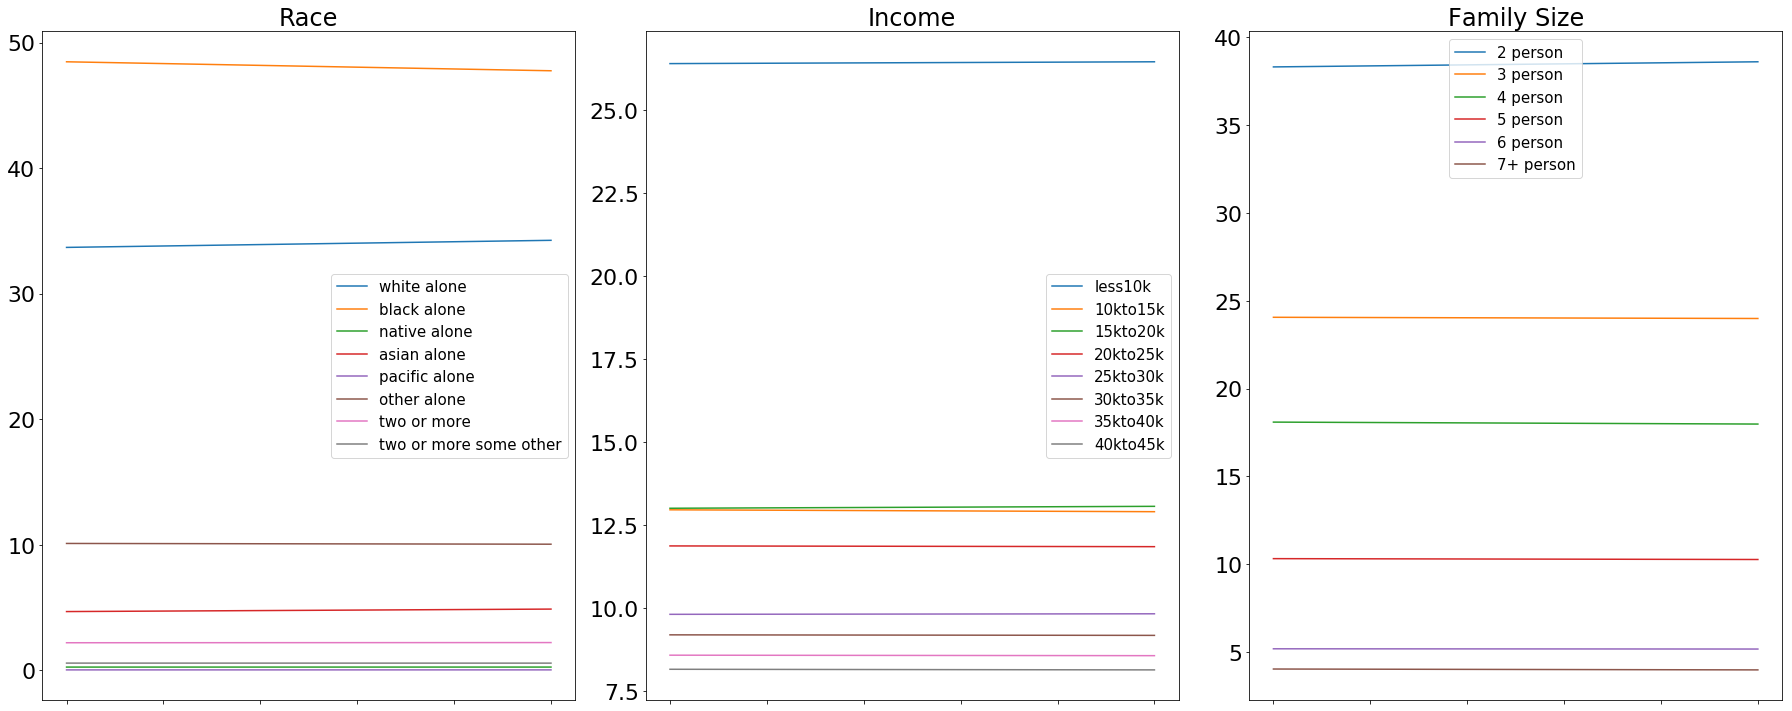

In [23]:
change_year('BATTERY')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


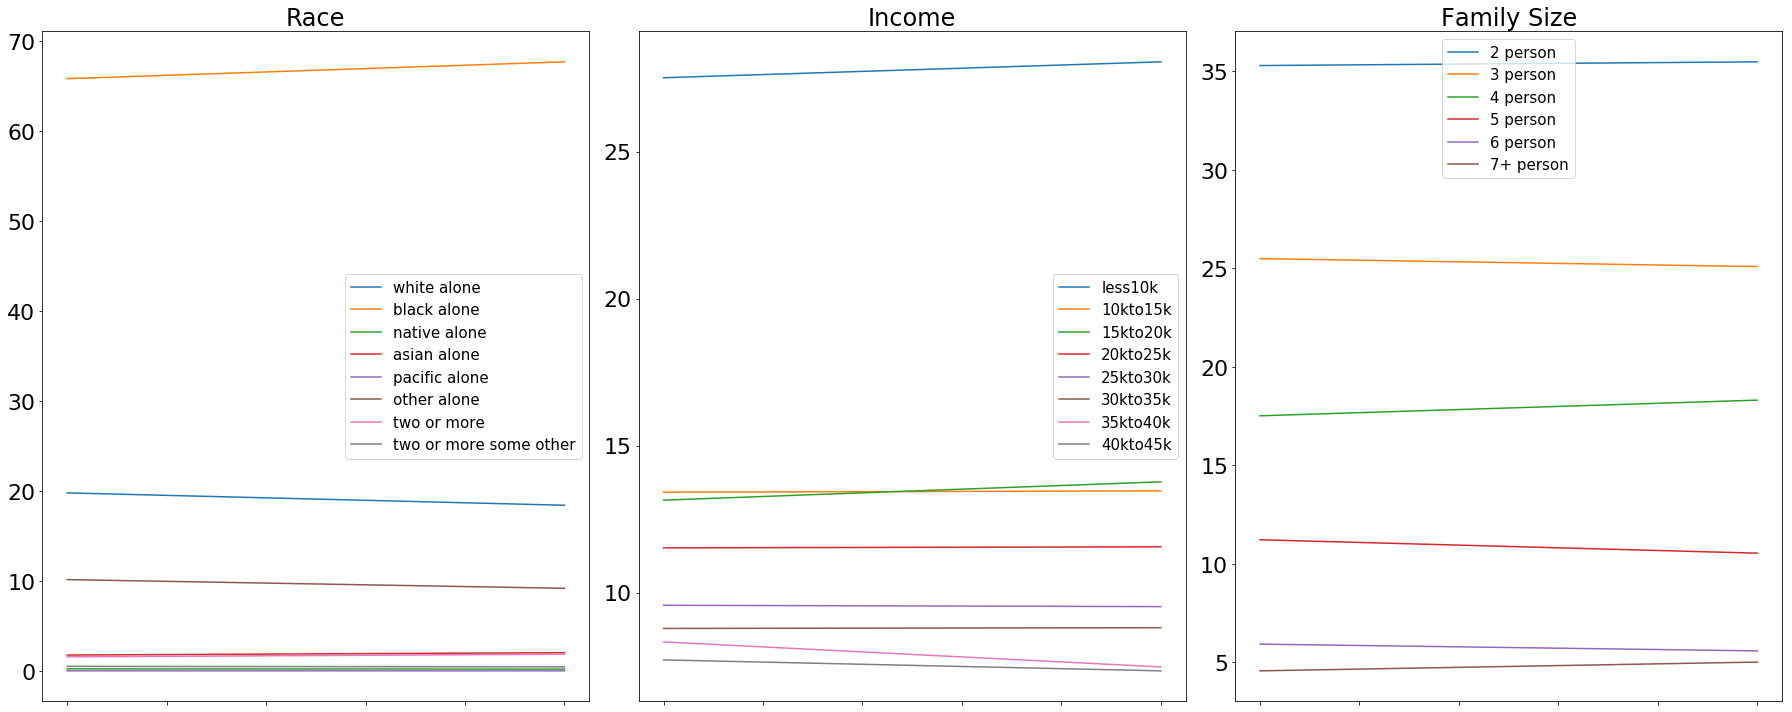

In [24]:
change_year('HOMICIDE')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


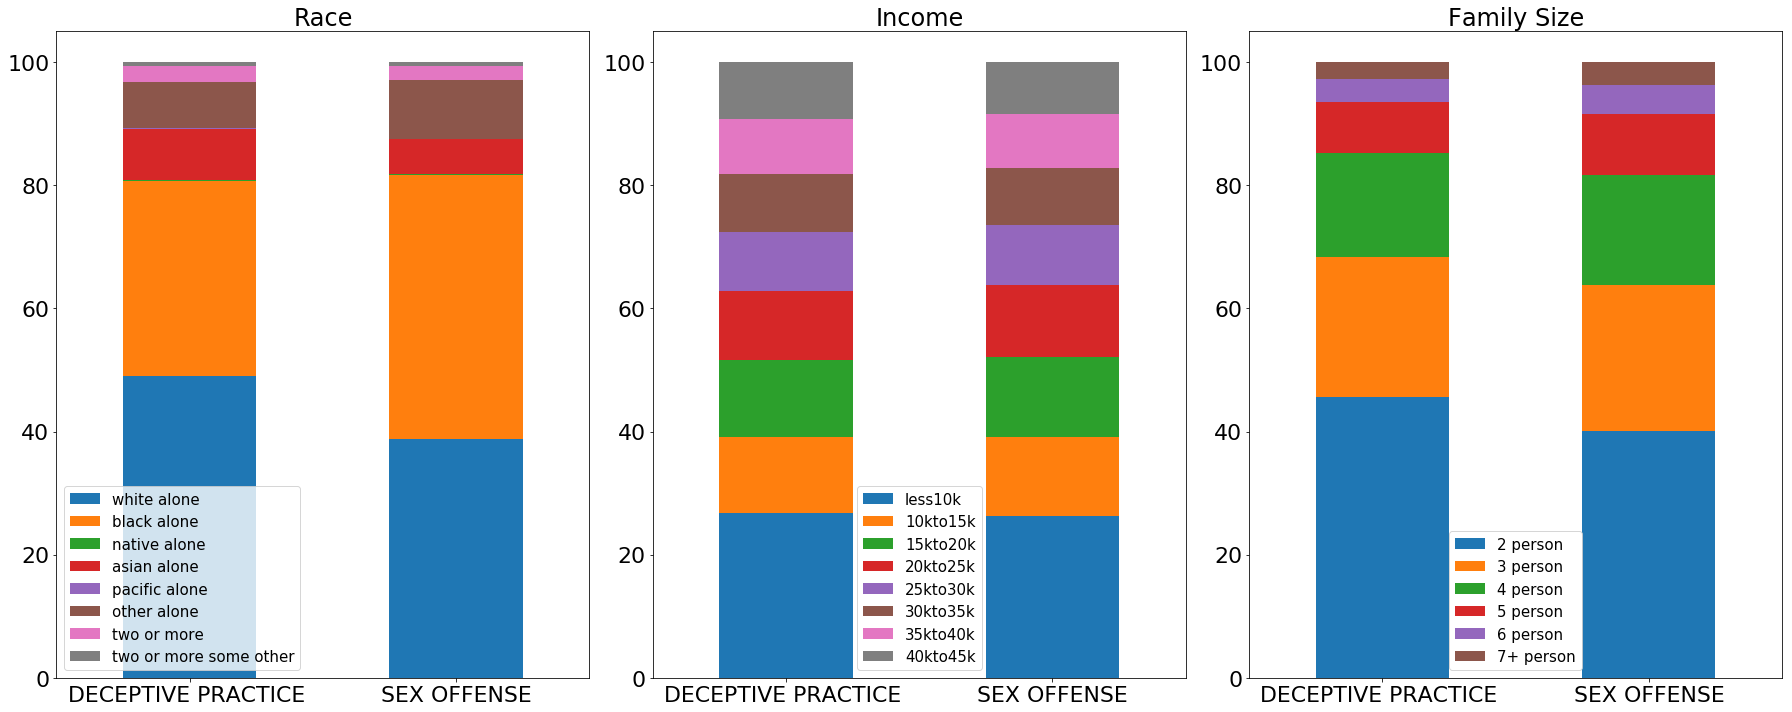

In [21]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 10))
    
for key, val in pref.items():
    small_df = delimit_df(final_join, 'DECEPTIVE PRACTICE','2018')
    small_df_perc = turn_to_perc(small_df, val, dcat[val])
    small_df_perc.rename(index={0:'{} '.format('DECEPTIVE PRACTICE')}, inplace=True)

    big_comparison = turn_to_perc(final_join, val, dcat[val])
    big_comparison.rename(index={0:'SEX OFFENSE'}, inplace = True)
    appended = small_df_perc.append(big_comparison)
    if key == 'Race':
        appended.plot(kind="bar", stacked = True, rot = 0, ax = ax1, title = key, fontsize = 22)
    elif key == 'Income':
        appended.plot(kind="bar", stacked = True, rot = 0, ax = ax2, title = key, fontsize = 22)
    elif key == 'Family Size':
        appended.plot(kind="bar", stacked = True, rot = 0, ax = ax3, title = key, fontsize = 22)
    ax1.title.set_size(24)
    ax2.title.set_size(24)
    ax3.title.set_size(24)
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax3.legend(prop={'size': 15})

    
plt.tight_layout()

## 2.4
Significant diffence in the demographic characteristics can be seen between block groups where deceptive practice felonies have been reported versus block groups in which sex offense has been reporter. White population is predominant in deceptive practice cases.  

## Question 3

##  3.1
Occurrence of the number of crimes in Chicago have not changed significantly from one year to the other (-0.7% less for 2018 regarding 2017). Nevertheless, this number hides many disparities.
The  most important types of crimes in terms of number of reports have not changed from year to year. Theft  (64024 cases) show slightly more occurencies (0.68% more for 2018), as well as battery, with 49720 cases  (1.18% more for 2018). On the other hand,  the fastest-growing types of crimes are Concealed carry license violation(114% more), Human Trafficking (75%) , Non-Criminal (50%) and Public Indecency(40%).
Breaking down the number of crimes by community areas we can observe a great disparity in the number of reports.  For 2018, the top five with less crime reports are Edinson Park  (250), Burnside(381), Forest Gien (486) , Mount Greenwood (553) and Montclare(592). The 5 with more crime reports are North Lawndale (9236), North West Side (9263), Loop(10666), Near North Side (12845) and Austin (14946). Crime reports have risen significantly in the following neighborhoods , Hyde Park  (14.27%), Lincoln Park(11.4%),  Pullman (10%), Garfield Ridge (8.67%) and Clearing(7.15%).
The kinds of block groups that report specific crimes are different from the general ones that compose Chicago  in terms of sociodemographic characteristics. 
The block groups that have reports of batteries are poorer. The distribution of income is show that there is more presence of households that earn less than 10k per year and 25k per year. Also, they are predominantly black 
For the block groups that have reported at least one homicide incident, we can clearly see that there is a racial component in the occurrence of these event. Block groups that report homicide are mainly inhabited by black people, while block groups that don't report homicide, are mainly white. The income level is worse in these blocks too.
For batteries, blocks with black populations are less representative and block populations, more representative.  For homicides, blocks with black population are much more representative in 2018. in the case of income, this characteristic is significant.



## 3.2
### 3.2.A
These statistics are not correct. According to the tables below, the variation rate of the crimes of motor vehicle theft, robbery and burglary are negative for the period of July 01 to July 26, 2018, with respect to the same time span in 2017. Motor vehicle theft, robbery, burglary and aggravated battery show a variation rate of -13.8%, -12%, -6.16%, and -0.29% respectively. 
The overall variation for all these crimes between 2017 and 2018 is 1.49%, so, even though it grew, it didn't at the pace this candidate tells. 


### 3.2.B
Even if correct, these statistics could be misleading because the candidate is taking a very specific time span, which doesn't reflect a real trend. Seasonalities will affect the conclusion.

In [25]:
# Part 3 
crime_data['month'] = pd.DatetimeIndex(crime_data['date']).month
crime_data['day'] = pd.DatetimeIndex(crime_data['date']).day
crime_d = crime_data.query('month == 7 & day < 27')

newdf = comm_area_df('primary_type',crime_d)
newdf = newdf[(newdf['primary_type'] =='ROBBERY')
              |(newdf['primary_type'] =='BATTERY')
              |(newdf['primary_type'] =='BURGLARY')
              |(newdf['primary_type'] =='MOTOR VEHICLE THEFT')]

newdf2 = crime_d[crime_d['primary_type'] =='BATTERY']
newdf2['aggravated'] = newdf2['description'].str.contains('AGGRAVATED')
newdf2 = newdf2[newdf2['aggravated'] == True]
newdf2 = comm_area_df('primary_type',newdf2)


crime_d['unit'] = 'one'
newdf3 = comm_area_df('unit',crime_d)
print(newdf3)

 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


  unit   2017   2018  Variation Rate
0  one  20601  20908        1.490219


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
newdf

,primary_type,2017,2018,Variation Rate
15,MOTOR VEHICLE THEFT,820.0,707.0,-13.780488
26,ROBBERY,842.0,741.0,-11.995249
3,BURGLARY,1023.0,960.0,-6.158358
2,BATTERY,3900.0,4147.0,6.333333


In [36]:
newdf2

,primary_type,2017,2018,Variation Rate
0,BATTERY,687,685,-0.291121


In [37]:
newdf3

,unit,2017,2018,Variation Rate
0,one,20601,20908,1.490219


## 3.3

1. Crime rate has dropped from 2017 to 2018 by 0.69%, still, some primary types of crime have risen. 

2. There are several neighborhoods in which crime reports are considerably high. If police action is not already concentrated in these neighborhoods, there should be. The following neighborhoods are particularly worrisome because of the crime reports they have: The 5 with more crime reports are North Lawndale (9236), North West Side (9263), Loop(10666), Near North Side (12845) and Austin (14946). 

3. Also there are several neighborhoods in which crimes have risen significantly. Police action should be reinforced in these neighborhoods: Hyde Park  (14.27%), Lincoln Park(11.4%),  Pullman (10%), Garfield Ridge (8.67%) and Clearing(7.15%).

4. On the other hand, there are community areas in which crime has also diminished significantly, so police action should be evaluated there. These neighborhoods are McKinley park, West Town, Gage Park, Forest Glen and Woodlawn. 

5. Even though there is a clear correlate between race, income and crime occurrence, it is hard to not think about this problem in structural terms. Not necessarily because certain kinds of crimes occur mainly in black of poor neighborhoods, police action should be reinforced there. This is the result of a broader problem that starts with the inclusion of this population in a social and economic sense. So policy should be aimed not only at reinforcing security in these neighborhoods but also other ways of inclusion (Education, Job opportunities). 




## 3.4
There are many caveats in the performed analysis. Some of them are:

1. For more concise recommendations we should take a look at the spatial distribution of crime. It would be interesting to see if there is a spatial correlation between both of them. Dividing the community areas into Chicago sides and then making maps of Chicago in which we explicitly see crime occurrences would enrich the analysis. 

2. We should take a look at the seasonality of crime. There are definitely months in which crime is more concentrated and taking this into account is important to draw more precise conclusions.

3. We should evaluate if the crimes in question are actually preventable. Analyzing where these crimes happened (inside a home, or in the streets) would help classify the types of crime that could actually be preventable. 

4. Information on ACS for block groups is not yet available for 2018, so the demographic characteristics are reused for both years of analysis. 



## Question 4 

### 4.A 
Given that 2111 S Michigan avenue will not appear in the database for privacy matters, we take instead information from 21xx S Michigan Avenue. According to this block's reports, the most common one for 2017 2018 is "Other Offense". 





,primary_type,year,count
0,BATTERY,2017,12
1,OTHER OFFENSE,2018,7
2,OTHER OFFENSE,2017,5
3,DECEPTIVE PRACTICE,2018,5
4,ASSAULT,2017,4
5,BATTERY,2018,4
6,THEFT,2017,4
7,CRIMINAL DAMAGE,2018,3
8,CRIMINAL DAMAGE,2017,3
9,ASSAULT,2018,2


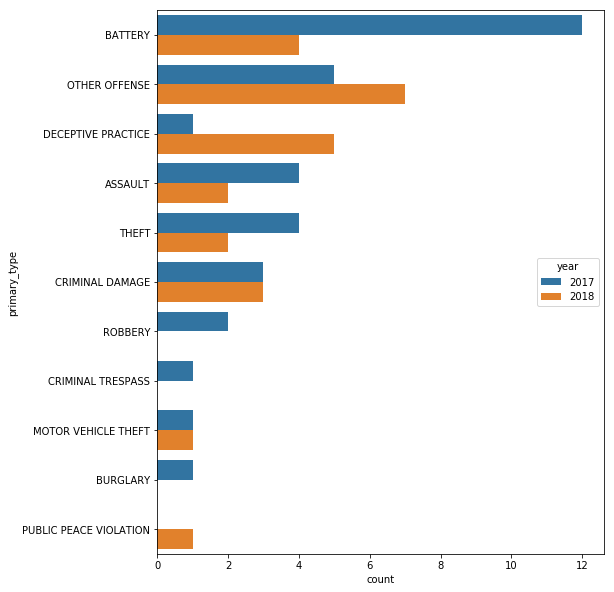

In [53]:
#Part 4
crime_data['michigan'] = crime_data['block'].str.contains('021XX S MICHIGAN')
newdf2 = crime_data[crime_data['michigan'] == True]
newdf = prim_type_df(['primary_type','year'],newdf2)
plt.figure(figsize=(8,10))
ax = sns.barplot(x="count", y="primary_type", hue = 'year', data=newdf)
newdf

## 4.2 

During 2018, the reported cases of theft for Uptown and Garfield have been 964 and 1325. It is more likely that the call comes from Garfield Park. The likelihood is 1325/964 = 1.37


In [52]:
#Part 4
crime_data_theft = crime_data[crime_data['primary_type'] == 'THEFT']
garfield_dict = {"West Garfield Park" : "Garfield Park",
"East Garfield Park": "Garfield Park", "Uptown": "Uptown"}
crime_data_theft['community area'] = crime_data_theft['community area'].map(garfield_dict)   
newdf = comm_area_df('community area',crime_data_theft)
newdf




/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,community area,2017,2018,Variation Rate
1,Uptown,955,964,0.942408
0,Garfield Park,1150,1325,15.217391


## 4.3
Given that there are 260 calls reporting Battery. 100 of them come from Garfield Park and 160, from Uptown. The likelihood that one of these calls come from Uptown is 160/100 = 1.6